In [1]:
import torch
from torch.cuda import is_available
from torch.optim import Adam
from torch.nn import MSELoss, BCELoss
import numpy as np
import matplotlib.pyplot as plt
import cv2
from torch.utils.data import Dataset, DataLoader
from utils import ims, imshow
from conv3d import Conv3D, PEI

### The outputs after each layer: 
`dim = (batch_size, channels, frames, height, width)`
* Conv3d layer 1: `(1, 16, 1, 160, 120)`

* Conv3d layer 2: `(1, 32, 1, 160, 120)`

* Conv3d layer 3: `(1, 16, 1, 160, 120)`

* Conv3d layer 4: `(1, 1, 1, 160, 120)`


In [2]:
model = Conv3D()
device = 'cuda:0'
print(device)
model.to(device)

cuda:0


Conv3D(
  (conv1): Sequential(
    (0): Conv3d(1, 16, kernel_size=(3, 1, 1), stride=(1, 1, 1))
    (1): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): MaxPool3d(kernel_size=(1, 1, 1), stride=(1, 1, 1), padding=0, dilation=1, ceil_mode=False)
    (3): ReLU()
  )
  (conv2): Sequential(
    (0): Conv3d(16, 32, kernel_size=(1, 1, 1), stride=(1, 1, 1))
    (1): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): MaxPool3d(kernel_size=(1, 1, 1), stride=(1, 1, 1), padding=0, dilation=1, ceil_mode=False)
    (3): ReLU()
  )
  (conv3): Sequential(
    (0): Conv3d(32, 16, kernel_size=(1, 1, 1), stride=(1, 1, 1))
    (1): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): MaxPool3d(kernel_size=(1, 1, 1), stride=(1, 1, 1), padding=0, dilation=1, ceil_mode=False)
    (3): ReLU()
  )
  (conv4): Sequential(
    (0): Conv3d(16, 1, kernel_size=(1, 1, 1), stride=(1, 1, 1))
    (1): BatchN

In [3]:
from pytictoc import TicToc
t = TicToc()

In [4]:
t.tic()
dataset = PEI(10, angle=0, keyposes=[4,5])
t.toc()

Elapsed time is 95.093456 seconds.


In [5]:
len(dataset)

137

In [6]:
train_dl = DataLoader(dataset,batch_size=1,shuffle=True)

In [7]:
#Loss
criterion = MSELoss()
#Optimizer
optimizer = Adam(model.parameters(), lr=0.002)

## Training

In [9]:
#Epochs
n_epochs = 5

for epoch in range(1, n_epochs+1):
    # monitor training loss
    train_loss = 0.0

    #Training
    for images,y in train_dl:
        images,y = images.to(device), y.to(device)
        # print('images.shape',images.shape)
        optimizer.zero_grad()

        out = model(images)
        # print(temp.shape)
        loss = criterion(out.view(out.shape[3],out.shape[4]), y)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
          
    train_loss = train_loss/len(train_dl)
    print('Epoch: {} \tTraining Loss: {:.6f}'.format(epoch, train_loss))

Epoch: 1 	Training Loss: 0.091174
Epoch: 2 	Training Loss: 0.069860
Epoch: 3 	Training Loss: 0.085572
Epoch: 4 	Training Loss: 0.079248
Epoch: 5 	Training Loss: 0.078687


## Check
`240 images (80 samples from 15 experiments, 3 frames each)`

In [10]:
def ims(model_out,actual):
    # img = img / 2 + 0.5  
    fig, axes = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True, figsize=(12,4))
    axes[0].imshow(model_out,cmap='gray',vmin=0,vmax=1)
    axes[0].set_title('Model')
    axes[1].imshow(actual,cmap='gray',vmin=0,vmax=1)
    axes[1].set_title('Average')
    plt.show()


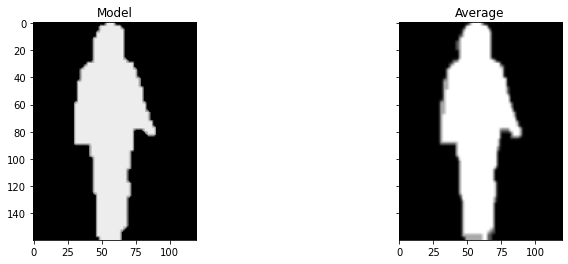

In [13]:
dataiter = iter(train_dl)
images, y = dataiter.next()
# images = images.to('cpu',dtype=torch.float)
# print(type(images),images.shape)

#Sample outputs
output = model(images.to(device=device))
images = images.cpu().numpy().reshape(3,160,120)
output = output.view(160, 120)
output = output.cpu().detach().numpy()

ims(output,y.view(160,120))

<ipython-input-14-a377d4ca0743>:5: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


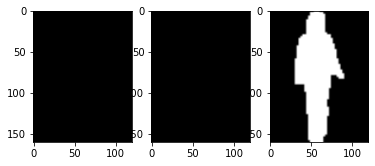

In [14]:
fig,ax = plt.subplots(nrows=1,ncols=3)
ax[0].imshow(images[0],cmap='gray')
ax[1].imshow(images[1],cmap='gray')
ax[2].imshow(images[2],cmap='gray')
fig.show()